IMPORTATION

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import textstat
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from src.features import *
import pickle

training_data = pd.read_excel('data/training_set_rel3.xls')

[nltk_data] Downloading package punkt to E:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to E:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     E:\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to E:\nltk_data...
[nltk_data]   Package words is already up-to-date!


FUNCTIONING

In [2]:
def quadratic_weighted_kappa(y_true, y_pred):
    """
    Calculate the Quadratic Weighted Kappa aka Cohen's Kappa.
    
    Args:
    y_true (list or array): True labels.
    y_pred (list or array): Predicted labels.
    
    Returns:
    float: The Quadratic Weighted Kappa Score.
    """
    assert len(y_true) == len(y_pred), "Length of true labels and predicted labels must be equal"
    
    O = np.zeros((max(y_true) + 1, max(y_true) + 1))
    W = np.zeros((max(y_true) + 1, max(y_true) + 1))
    
    for i in range(len(y_true)):
        O[y_true[i]][y_pred[i]] += 1
    
    for i in range(len(W)):
        for j in range(len(W)):
            W[i][j] = float((i - j) ** 2) / (len(W) - 1) ** 2
    
    E = np.outer(np.sum(O, axis=1), np.sum(O, axis=0)) / np.sum(O)
    
    num = np.sum(W * O)
    den = np.sum(W * E)
    
    return 1 - num / den

def DATAFRAME_SCALER(df, remove_useless_columns=True, range_of_scaling=(-1, 1), display_distribution=False):
    """
    Scale specific columns in the dataframe based on conditions and optionally remove selected columns.

    Args:
        df (DataFrame): The input dataframe to process.
        remove_useless_columns (bool, optional): Flag to remove specified columns. Defaults to True.
        range_of_scaling (tuple, optional): The range used for scaling. Defaults to (-1,1).
        display_distribution (bool, optional): Flag to display distribution of scaled scores. Defaults to False.

    Returns:
        DataFrame: The processed dataframe with scaled scores and optionally removed columns.
    """
    # Dictionary to store scalers
    scalers_dict = {}

    # --- DOMAIN 1 HANDLING ---
    scaled_domain1_score_list = []
    for i in np.arange(8):
        df_temp = df[df["essay_set"] == i+1].copy()  # parsing essay set
        domain_score = np.array(df_temp["domain1_score"]).reshape(-1, 1)  # turning score column in array
        scaler = MinMaxScaler(feature_range=range_of_scaling)  # scaler
        scaler.fit(domain_score)  # fitting ...
        df_temp["scaled_domain1_score"] = scaler.transform(domain_score)  # scaling the score column
        scaled_domain1_score_list.append(df_temp[["scaled_domain1_score"]])  # add the scaled column to lists
        
        # Save the scaler with essay_set as the key
        scalers_dict[f"domain1_essay_set_{i+1}"] = scaler

    scaled_scores_df = pd.concat(scaled_domain1_score_list)
    df = df.join(scaled_scores_df)

    # --- DOMAIN 2 HANDLING ---
    scaler2 = MinMaxScaler(feature_range=range_of_scaling)
    x = np.array(df["domain2_score"]).reshape(-1, 1)
    scaler2.fit(x)
    df["scaled_domain2_score"] = scaler2.transform(x)

    # Save the scaler for domain2
    scalers_dict["domain2"] = scaler2

    if remove_useless_columns:
        df = df.drop(['rater1_domain1', 'rater2_domain1', 'rater3_domain1', 
                      'rater1_domain2', 'rater2_domain2', 'rater1_trait1',       
                      'rater1_trait2', 'rater1_trait3', 'rater1_trait4', 
                      'rater1_trait5', 'rater1_trait6', 'rater2_trait1', 
                      'rater2_trait2', 'rater2_trait3', 'rater2_trait4', 
                      'rater2_trait5', 'rater2_trait6', 'rater3_trait1', 
                      'rater3_trait2', 'rater3_trait3', 'rater3_trait4', 
                      'rater3_trait5', 'rater3_trait6'], axis=1)

    if display_distribution:
        plt.figure(figsize=(20, 6))
        plt.suptitle("With parsed scaling")

        plt.subplot(1, 2, 1)
        plt.hist(df['scaled_domain1_score'], edgecolor='black')
        plt.title('domain1_score')
        plt.xlabel('value')
        plt.ylabel('freq')

        plt.subplot(1, 2, 2)
        plt.hist(df['scaled_domain2_score'], edgecolor='black')
        plt.title('domain2_score')
        plt.xlabel('value')
        plt.ylabel('freq')

        plt.show()

    # Return the processed dataframe and the dictionary of scalers
    return df, scalers_dict

def FEATURE_ENGINEERING(df):
    df["count_characters"] = df["essay"].apply(lambda x: count_characters(x))
    df["count_syllables"] = df["essay"].apply(lambda x: count_syllables(x))
    df["ratio_monosyllable"] = df["essay"].apply(lambda x: ratio_monosyllable(x))
    df["count_words"] = df["essay"].apply(lambda x: count_words(x))
    df["count_sentences"] = df["essay"].apply(lambda x: count_sentences(x))
    df["flesch_reading_ease"] = df["essay"].apply(lambda x: get_flesch_reading_ease(x))
    df["gunning_fog"] = df["essay"].apply(lambda x: get_gunning_fog(x))
    df["automated_readability_index"] = df["essay"].apply(lambda x: get_automated_readability_index(x))
    df["smog_index"] = df["essay"].apply(lambda x: get_smog_index(x))
    df["flesch_kincaid_grade"] = df["essay"].apply(lambda x: get_flesch_kincaid_grade(x))
    df["coleman_liau_index"] = df["essay"].apply(lambda x: get_coleman_liau_index(x))
    df["dale_chall_readability_score"] = df["essay"].apply(lambda x: get_dale_chall_readability_score(x))
    df["automated_readability_index"] = df["essay"].apply(lambda x: get_automated_readability_index(x))
    df["dale_chall_readability_score"] = df["essay"].apply(lambda x: get_dale_chall_readability_score(x))
    df["difficult_words"] = df["essay"].apply(lambda x: get_difficult_words(x))
    df["linsear_write_formula"] = df["essay"].apply(lambda x: get_linsear_write_formula(x))
    df["count_awl_words"] = df["essay"].apply(lambda x: count_awl_words(x))
    df["calculate_lexical_diversity"] = df["essay"].apply(lambda x: calculate_lexical_diversity(x))
    df["get_average_heights"] = df["essay"].apply(lambda x: get_average_heights(x))
    df["get_average_connections_at_root"] = df["essay"].apply(lambda x: get_average_connections_at_root(x))
    df["get_length_of_clauses"] = df["essay"].apply(lambda x: get_length_of_clauses(x))
    df["calculate_misspelling_score"] = df["essay"].apply(lambda x: calculate_misspelling_score(x))
    df["detect_slur_usage"] = df["essay"].apply(lambda x: detect_slur_usage(x))
    df["calculate_overusage_of_punctuation"] = df["essay"].apply(lambda x: calculate_overusage_of_punctuation(x))
    df["count_tagged_entity"] = df["essay"].apply(lambda x: count_tagged_entity(x))
    df["count_stop_words"] = df["essay"].apply(lambda x: count_stop_words(x))
    df["count_quoted_words"] = df["essay"].apply(lambda x: count_quoted_words(x))

    tmp_df = pd.DataFrame()
    tmp_df = df["essay"].apply(lambda x: get_pos_tags(x))
    tmp_df = pd.json_normalize(tmp_df)
    df = df.join(tmp_df, how="left")

    tmp_df = pd.DataFrame()
    tmp_df = df["essay"].apply(lambda x: get_word_frequency(x))
    tmp_df = pd.json_normalize(tmp_df)
    df = df.join(tmp_df, how="left")

    tmp_df = pd.DataFrame()
    tmp_df = df["essay"].apply(lambda x: get_sentence_tree_roots(x))
    tmp_df = pd.json_normalize(tmp_df)
    tmp_df.fillna(0, inplace=True)
    df = df.join(tmp_df, how="left")
    
    with open("processed_data.pickle", "wb") as file:
        pickle.dump(df, file)
    return df

def GET_PREDICTIONS(df, plot=False,MSE=False):
    df_for_reverse_scaling = df.drop(['essay','domain2_score','scaled_domain2_score'], axis=1).dropna()
    df_pre_features = df.drop(['essay_id', 'essay_set', 'essay', "domain1_score",'domain2_score','scaled_domain2_score'], axis=1).dropna()
    df_features = df_pre_features.drop(["scaled_domain1_score"],axis=1)
    df_target = df_pre_features['scaled_domain1_score']

    scaler = MinMaxScaler(feature_range=(-1,1))
    df_features_scaled = scaler.fit_transform(df_features)

    X = df_features_scaled
    y = df_target

    params = {
      'objective': 'reg:squarederror',
      'n_estimators': 100,
      'learning_rate': 0.1,
      'max_depth': 5,
      'gamma': 0.1,
      'reg_alpha': 0.001,
      'reg_lambda': 1
    }

    model = XGBRegressor(**params)
    model.fit(X, y)

    predictions = model.predict(X)

    if MSE:
        print('MSE:', mean_squared_error(y, predictions))
    
    if plot:
        importances = model.feature_importances_
        sorted_idx = np.argsort(importances)[::-1] 
        sorted_importances = importances[sorted_idx]
        sorted_features = df_features.columns[sorted_idx]

        plt.figure(figsize=(15,5))
        plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_features)
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.ylim(0, 1)

        plt.xticks(rotation=45)

        plt.show()

    return df_for_reverse_scaling,predictions

def REVERSE_PREDICTIONS(df, scalers_dict, essay_set_column='essay_set', predictions_column='pred'):


    """
    Apply inverse transformation on the predictions column of the dataframe using the appropriate scaler
    from the scalers_dict based on the essay set.

    Args:
        df (DataFrame): The dataframe containing the predictions and essay sets.
        scalers_dict (dict): A dictionary of MinMaxScaler objects for each essay set.
        essay_set_column (str, optional): The name of the column containing the essay set IDs. Defaults to 'essay_set'.
        predictions_column (str, optional): The name of the column containing the scaled predictions. Defaults to 'predictions'.

    Returns:
        DataFrame: The dataframe with an additional column 'pred_reversed' containing the inverse transformed predictions.
    """
    inverse_predictions = []
    
    for index, row in df.iterrows():
        essay_set = row[essay_set_column]
        
        scaler_key = f"domain1_essay_set_{int(essay_set)}"
        scaler = scalers_dict.get(scaler_key, None)
        
        if scaler is not None:
            pred_value = row[predictions_column]
            inverse_pred = scaler.inverse_transform([[pred_value]])[0][0]
            inverse_predictions.append(inverse_pred)
        else:
            inverse_predictions.append(np.nan)
    
    df['pred_reversed'] = inverse_predictions
    
    
    return df

def SHOW_RESULTS(df,pred,scalers_dict):
    df["pred"] = pred
    df = REVERSE_PREDICTIONS(df,scalers_dict=scalers_dict)
    df['pred_reversed'] = np.round(df['pred_reversed'])
    df['pred_reversed'] = df['pred_reversed'].astype('Int64')
    df["rounded_score"] = df["domain1_score"].astype('Int64')
    df = df.reset_index(drop=True)
    QWK = quadratic_weighted_kappa(df["rounded_score"],df["pred_reversed"])
    print("Quadratic Weight Kappa : ",QWK)

SCALING THE DATAFRAME

In [3]:
scaled_df,scalers_dict = DATAFRAME_SCALER(training_data)

ENGINEERING THE FEATURE

In [4]:
featured_df = FEATURE_ENGINEERING(scaled_df)

In [5]:
featured_df.to_excel("featured_df.xlsx")

PREDICTING 

MSE: 0.06357551861481334


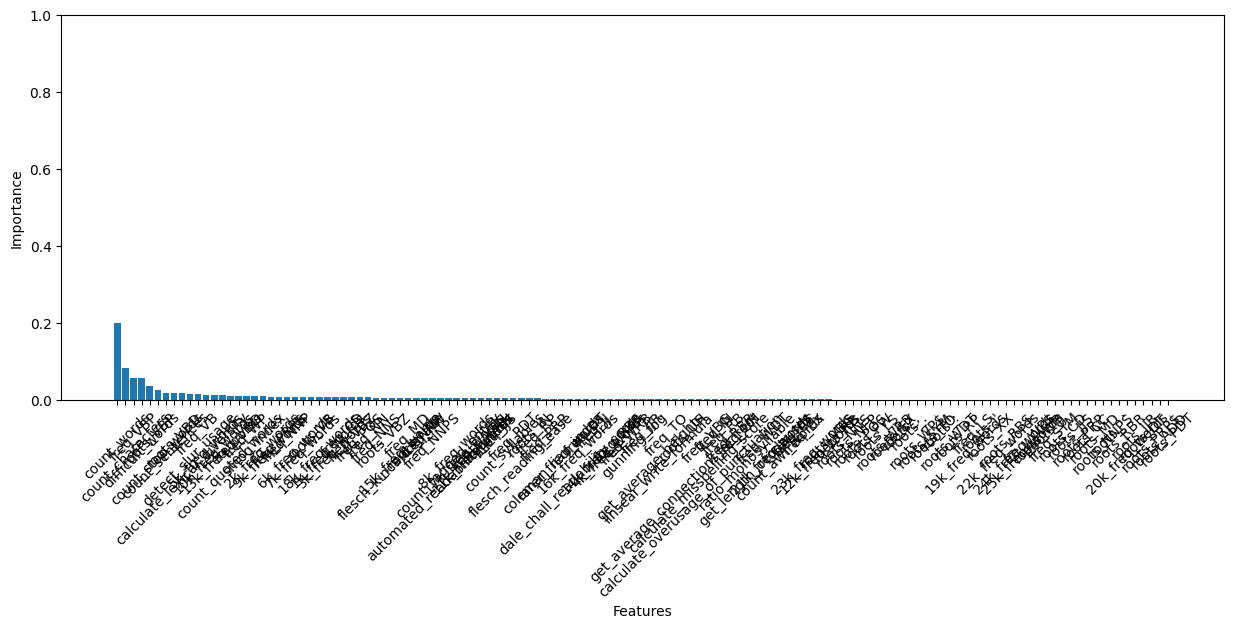

In [6]:
scoring_df, pred = GET_PREDICTIONS(featured_df,plot=True,MSE=True)

GET PERFOMRANCE METRIC

In [7]:
SHOW_RESULTS(scoring_df,pred,scalers_dict)

Quadratic Weight Kappa :  0.9828007962229761


# Next steps

- Try different classification models to predict essay_set from the essay*
- Add way more features for the regression model
- Try different regression model*
- Add validation set score
- Create a comparison table of all the tries 
- Clean the github and the read.me file
- Create a web app to allow user to test it with its own essay (using streamlit for example)

In [8]:
# stratify to get balanced split
# 100 validation
# 100 test
# balance the rest (training set)
# sklearn vectorizing
# compose vectorizing + features to train models
# cross validation / grid search
# metrics for every set
# USE PLOTLY
# training and prediction on different sets